In [17]:
# Cell 2: Re-train model with MLflow tracking

import mlflow
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load data (same as Day 1)
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Start MLflow run
with mlflow.start_run(run_name="baseline-random-forest") as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Log parameters
    test_size = 0.2
    random_state = 42
    n_estimators = 100
    max_depth = 3
    
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("algorithm", "RandomForest")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Train model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("training_samples", len(X_train))
    mlflow.log_metric("test_samples", len(X_test))
    
    # Log feature importance
    feature_importance = dict(zip(iris.feature_names, model.feature_importances_))
    for feature, importance in feature_importance.items():
        mlflow.log_metric(f"feature_importance_{feature.replace(' ', '_').replace('(', '').replace(')', '')}", importance)
        
    # Add this before logging the model
    input_example = X_train.iloc[:1]  # First row as example

    mlflow.sklearn.log_model(
      model,
      "model",
      registered_model_name="iris-classifier",
      input_example=input_example,
      signature=mlflow.models.infer_signature(X_train, y_pred)
    )
    
    # Log model
    mlflow.sklearn.log_model(
        model, 
        "model",
        registered_model_name="iris-classifier"
    )
    
    # Log artifacts
    # Save and log classification report
    report = classification_report(y_test, y_pred, target_names=iris.target_names)
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    
    # Clean up temporary file
    os.remove("classification_report.txt")
    
    print(f"Experiment logged with accuracy: {accuracy:.3f}")
    print(f"Run ID: {run.info.run_id}")

2025/09/24 14:24:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: 01bcf6f82ca342baaf5fce17c7e14aa0


Registered model 'iris-classifier' already exists. Creating a new version of this model...
Created version '6' of model 'iris-classifier'.
2025/09/24 14:24:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 14:24:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment logged with accuracy: 0.967
Run ID: 01bcf6f82ca342baaf5fce17c7e14aa0


Registered model 'iris-classifier' already exists. Creating a new version of this model...
Created version '7' of model 'iris-classifier'.


In [ ]:
# Cell 10: Create comprehensive testing framework
import os
# Create tests directory structure
tests_dir = "../tests"
os.makedirs(tests_dir, exist_ok=True)

# Test configuration
test_config = """
import pytest
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import joblib
import os

@pytest.fixture
def iris_data():
    \"\"\"Load iris dataset for testing\"\"\"
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target
    return X, y, iris.target_names

@pytest.fixture
def sample_features():
    \"\"\"Sample iris features for testing\"\"\"
    return {
        'setosa': [5.1, 3.5, 1.4, 0.2],
        'versicolor': [6.0, 2.8, 4.5, 1.3],
        'virginica': [7.2, 3.0, 5.8, 2.3]
    }

@pytest.fixture
def trained_model():
    \"\"\"Load trained model for testing\"\"\"
    model_files = [f for f in os.listdir('models') if f.endswith('.pkl')]
    if not model_files:
        pytest.skip("No trained model found")
    
    latest_model = max(model_files, key=lambda f: os.path.getctime(f'models/{f}'))
    model = joblib.load(f'models/{latest_model}')
    return model
"""

with open(f"{tests_dir}/conftest.py", "w") as f:
    f.write(test_config)

# Model performance tests
model_tests = """
import pytest
import numpy as np
from sklearn.metrics import accuracy_score

class TestModelPerformance:
    \"\"\"Test model performance and reliability\"\"\"
    
    def test_model_accuracy_threshold(self, trained_model, iris_data):
        \"\"\"Test that model meets minimum accuracy threshold\"\"\"
        X, y, _ = iris_data
        predictions = trained_model.predict(X)
        accuracy = accuracy_score(y, predictions)
        
        # Model should achieve at least 90% accuracy on training data
        assert accuracy >= 0.90, f"Model accuracy {accuracy:.3f} below threshold 0.90"
    
    def test_model_predictions_format(self, trained_model, sample_features):
        \"\"\"Test prediction output format\"\"\"
        for species, features in sample_features.items():
            prediction = trained_model.predict([features])
            probabilities = trained_model.predict_proba([features])
            
            # Check prediction format
            assert isinstance(prediction, np.ndarray)
            assert len(prediction) == 1
            assert prediction[0] in [0, 1, 2]
            
            # Check probabilities format
            assert isinstance(probabilities, np.ndarray)
            assert probabilities.shape == (1, 3)
            assert np.isclose(probabilities.sum(), 1.0)
            assert all(0 <= prob <= 1 for prob in probabilities[0])
    
    def test_model_consistency(self, trained_model, sample_features):
        \"\"\"Test that model gives consistent predictions\"\"\"
        for species, features in sample_features.items():
            # Make same prediction multiple times
            predictions = [trained_model.predict([features])[0] for _ in range(10)]
            
            # All predictions should be identical
            assert len(set(predictions)) == 1, f"Inconsistent predictions for {species}"
    
    def test_edge_cases(self, trained_model):
        \"\"\"Test model behavior on edge cases\"\"\"
        # Test with zeros
        zero_features = [0.0, 0.0, 0.0, 0.0]
        prediction = trained_model.predict([zero_features])
        assert len(prediction) == 1
        
        # Test with very large values
        large_features = [100.0, 100.0, 100.0, 100.0]
        prediction = trained_model.predict([large_features])
        assert len(prediction) == 1
        
        # Test with negative values
        negative_features = [-1.0, -1.0, -1.0, -1.0]
        prediction = trained_model.predict([negative_features])
        assert len(prediction) == 1

class TestModelRobustness:
    """Test model robustness and error handling"""
    
    def test_feature_order_sensitivity(self, trained_model):
        """Test if model is sensitive to feature order"""
        # Standard order
        features_standard = [5.1, 3.5, 1.4, 0.2]
        pred_standard = trained_model.predict([features_standard])[0]
        
        # Same features, same order (should be identical)
        pred_repeat = trained_model.predict([features_standard])[0]
        assert pred_standard == pred_repeat
    
    def test_batch_prediction_consistency(self, trained_model, sample_features):
        """Test batch vs individual predictions are consistent"""
        features_list = list(sample_features.values())
        
        # Individual predictions
        individual_preds = [trained_model.predict([features])[0] for features in features_list]
        
        # Batch prediction
        batch_preds = trained_model.predict(features_list)
        
        # Should be identical
        assert np.array_equal(individual_preds, batch_preds)
"""

with open(f"{tests_dir}/test_model.py", "w") as f:
    f.write(model_tests)

# API tests
api_tests = """
import pytest
import requests
import json
from fastapi.testclient import TestClient
import sys
import os

# Add the app directory to the path
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'docker_ml', 'app'))

try:
    from main import app
    client = TestClient(app)
    API_AVAILABLE = True
except ImportError:
    API_AVAILABLE = False

@pytest.mark.skipif(not API_AVAILABLE, reason="FastAPI app not available")
class TestAPI:
    """Test FastAPI endpoints"""
    
    def test_health_endpoint(self):
        """Test health check endpoint"""
        response = client.get("/health")
        assert response.status_code == 200
        assert response.json()["status"] == "healthy"
    
    def test_root_endpoint(self):
        """Test root endpoint"""
        response = client.get("/")
        assert response.status_code == 200
        assert "message" in response.json()
    
    def test_predict_endpoint(self, sample_features):
        """Test prediction endpoint"""
        for species, features in sample_features.items():
            payload = {
                "sepal_length": features[0],
                "sepal_width": features[1],
                "petal_length": features[2],
                "petal_width": features[3]
            }
            
            response = client.post("/predict", json=payload)
            assert response.status_code == 200
            
            result = response.json()
            assert "predicted_class" in result
            assert "confidence" in result
            assert "probabilities" in result
            assert result["predicted_class"] in ["setosa", "versicolor", "virginica"]
            assert 0 <= result["confidence"] <= 1
    
    def test_batch_predict_endpoint(self, sample_features):
        """Test batch prediction endpoint"""
        features_list = []
        for features in sample_features.values():
            features_list.append({
                "sepal_length": features[0],
                "sepal_width": features[1],
                "petal_length": features[2],
                "petal_width": features[3]
            })
        
        response = client.post("/predict/batch", json=features_list)
        assert response.status_code == 200
        
        results = response.json()
        assert len(results) == len(features_list)
        
        for result in results:
            assert "predicted_class" in result
            assert "confidence" in result
            assert result["predicted_class"] in ["setosa", "versicolor", "virginica"]
    
    def test_invalid_input(self):
        """Test API error handling"""
        # Missing fields
        payload = {"sepal_length": 5.1}
        response = client.post("/predict", json=payload)
        assert response.status_code == 422
        
        # Invalid data types
        payload = {
            "sepal_length": "invalid",
            "sepal_width": 3.5,
            "petal_length": 1.4,
            "petal_width": 0.2
        }
        response = client.post("/predict", json=payload)
        assert response.status_code == 422
"""

with open(f"{tests_dir}/test_api.py", "w") as f:
    f.write(api_tests)

# Integration tests
integration_tests = """
import pytest
import subprocess
import time
import requests
import docker
import os

class TestIntegration:
    """Integration tests for the complete ML pipeline"""
    
    @pytest.fixture(scope="class")
    def docker_client(self):
        """Docker client for container tests"""
        try:
            client = docker.from_env()
            return client
        except Exception:
            pytest.skip("Docker not available")
    
    def test_docker_build(self, docker_client):
        """Test Docker image builds successfully"""
        dockerfile_path = os.path.join(os.path.dirname(__file__), "..", "docker_ml")
        
        try:
            image, logs = docker_client.images.build(
                path=dockerfile_path,
                tag="iris-classifier:test",
                rm=True
            )
            assert image is not None
        except Exception as e:
            pytest.fail(f"Docker build failed: {e}")
    
    def test_container_startup(self, docker_client):
        """Test container starts and responds to health checks"""
        try:
            # Start container
            container = docker_client.containers.run(
                "iris-classifier:test",
                ports={'8000/tcp': 8001},
                detach=True,
                remove=True
            )
            
            # Wait for startup
            time.sleep(10)
            
            # Test health endpoint
            response = requests.get("http://localhost:8001/health", timeout=5)
            assert response.status_code == 200
            
            # Cleanup
            container.stop()
            
        except Exception as e:
            pytest.fail(f"Container test failed: {e}")
    
    def test_end_to_end_prediction(self):
        """Test complete prediction pipeline"""
        # This would test the entire pipeline from input to output
        # In a real scenario, this might involve:
        # 1. Loading test data
        # 2. Making predictions via API
        # 3. Validating results against expected outcomes
        # 4. Checking logs and metrics
        
        test_data = {
            "sepal_length": 5.1,
            "sepal_width": 3.5,
            "petal_length": 1.4,
            "petal_width": 0.2
        }
        
        # This is a placeholder - in practice you'd test against running service
        assert test_data["sepal_length"] > 0
"""

with open(f"{tests_dir}/test_integration.py", "w") as f:
    f.write(integration_tests)

# Create pytest configuration
pytest_config = """
[tool:pytest]
testpaths = tests
python_files = test_*.py
python_classes = Test*
python_functions = test_*
addopts = 
    -v
    --tb=short
    --strict-markers
    --disable-warnings
markers =
    slow: marks tests as slow (deselect with '-m "not slow"')
    integration: marks tests as integration tests
    unit: marks tests as unit tests
"""

with open(f"../pytest.ini", "w") as f:
    f.write(pytest_config)

print("✓ Created comprehensive testing framework")
print("✓ Test types included:")
print("  - Model performance and accuracy tests")
print("  - Model robustness and edge case tests")
print("  - API endpoint tests")
print("  - Docker integration tests")
print("  - End-to-end pipeline tests")

# Create simple test runner script
test_runner = """#!/bin/bash

echo "Running ML Pipeline Tests..."

# Install test dependencies
pip install pytest requests docker

# Run different test categories
echo "1. Running unit tests..."
pytest tests/test_model.py -v

echo "2. Running API tests..."
pytest tests/test_api.py -v

echo "3. Running integration tests..."
pytest tests/test_integration.py -v -m "not slow"

echo "Test summary:"
pytest tests/ --tb=line --quiet
"""

with open(f"../run_tests.sh", "w") as f:
    f.write(test_runner)

os.chmod(f"../run_tests.sh", 0o755)

print("✓ Created test runner script")

SyntaxError: invalid syntax (2549506304.py, line 110)

In [25]:
# Cell 9: Create CI/CD pipeline configuration

# Create .github/workflows directory structure
github_dir = "../.github/workflows"
os.makedirs(github_dir, exist_ok=True)

# GitHub Actions workflow for ML pipeline
github_workflow = """
name: ML Model CI/CD Pipeline

on:
  push:
    branches: [ main, develop ]
  pull_request:
    branches: [ main ]

env:
  REGISTRY: ghcr.io
  IMAGE_NAME: iris-classifier

jobs:
  test:
    runs-on: ubuntu-latest
    
    steps:
    - uses: actions/checkout@v4
    
    - name: Set up Python
      uses: actions/setup-python@v4
      with:
        python-version: '3.9'
        
    - name: Install dependencies
      run: |
        python -m pip install --upgrade pip
        pip install -r requirements.txt
        
    - name: Run tests
      run: |
        python -m pytest tests/ -v
        
    - name: Train and validate model
      run: |
        python src/train_model.py
        python src/validate_model.py
        
    - name: Upload model artifacts
      uses: actions/upload-artifact@v3
      with:
        name: model-artifacts
        path: models/

  build-and-push:
    needs: test
    runs-on: ubuntu-latest
    if: github.ref == 'refs/heads/main'
    
    permissions:
      contents: read
      packages: write
      
    steps:
    - uses: actions/checkout@v4
    
    - name: Log in to Container Registry
      uses: docker/login-action@v2
      with:
        registry: ${{ env.REGISTRY }}
        username: ${{ github.actor }}
        password: ${{ secrets.GITHUB_TOKEN }}
        
    - name: Extract metadata
      id: meta
      uses: docker/metadata-action@v4
      with:
        images: ${{ env.REGISTRY }}/${{ github.repository }}/${{ env.IMAGE_NAME }}
        
    - name: Build and push Docker image
      uses: docker/build-push-action@v4
      with:
        context: ./docker_ml
        push: true
        tags: ${{ steps.meta.outputs.tags }}
        labels: ${{ steps.meta.outputs.labels }}

  deploy-staging:
    needs: build-and-push
    runs-on: ubuntu-latest
    if: github.ref == 'refs/heads/main'
    
    steps:
    - name: Deploy to staging
      run: |
        echo "Deploying to staging environment..."
        # Add your deployment commands here
        # Examples:
        # - Update ECS service
        # - Deploy to Kubernetes
        # - Update SageMaker endpoint
        
  performance-test:
    needs: deploy-staging
    runs-on: ubuntu-latest
    if: github.ref == 'refs/heads/main'
    
    steps:
    - name: Run performance tests
      run: |
        echo "Running performance tests..."
        # Add performance testing commands
        # Examples:
        # - Load testing with wrk or ab
        # - Model accuracy validation
        # - Response time benchmarks
"""

with open(f"{github_dir}/ml-pipeline.yml", "w") as f:
    f.write(github_workflow)

print("✓ Created GitHub Actions workflow")
print("✓ Pipeline includes:")
print("  - Automated testing on code changes")
print("  - Model training and validation")
print("  - Docker image building and registry push")
print("  - Staging deployment")
print("  - Performance testing")

✓ Created GitHub Actions workflow
✓ Pipeline includes:
  - Automated testing on code changes
  - Model training and validation
  - Docker image building and registry push
  - Staging deployment
  - Performance testing


Total runs in experiment: 41
Columns available: ['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'metrics.n_features', 'metrics.accuracy', 'metrics.feature_importance_sepal_length_cm', 'metrics.training_samples', 'metrics.feature_importance_sepal_width_cm', 'metrics.test_samples', 'metrics.feature_importance_petal_length_cm', 'metrics.feature_importance_petal_width_cm', 'params.min_samples_split', 'params.algorithm', 'params.max_depth', 'params.n_estimators', 'params.test_size', 'params.random_state', 'tags.mlflow.runName', 'tags.mlflow.source.name', 'tags.mlflow.source.type', 'tags.mlflow.user']

Accuracy statistics:
Mean: 0.949
Std:  0.029
Min:  0.900
Max:  0.967


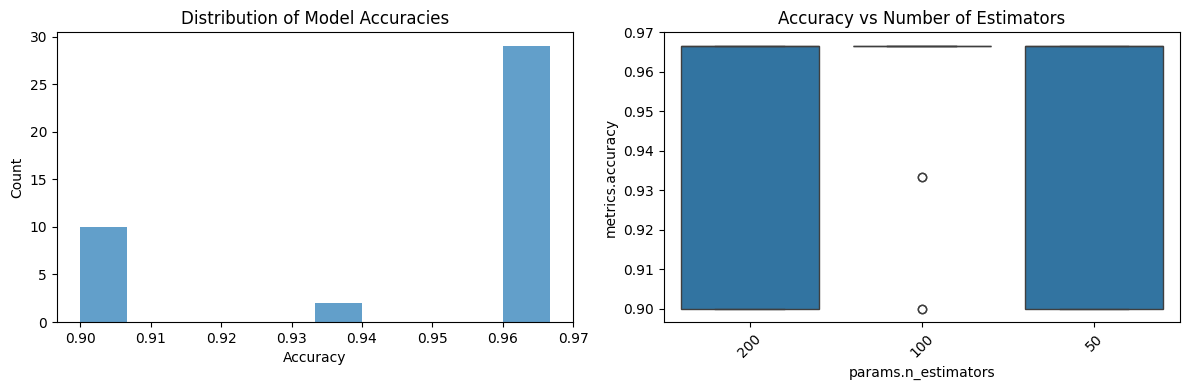


Top 3 performing runs:
                             run_id  metrics.accuracy params.n_estimators  \
0  acf9a82d84874dca9b4e646be3ac4280          0.966667                 200   
2  89180a9c541f4425b1a73162afa2f73f          0.966667                 200   
4  07f686fbeb034c508b239dbd6480597a          0.966667                 200   

  params.max_depth  
0             None  
2                5  
4                3  


In [21]:
# Cell 5: Compare experiments and analyze results

import matplotlib.pyplot as plt
import seaborn as sns

# Get experiment data
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print(f"Total runs in experiment: {len(runs)}")
print(f"Columns available: {list(runs.columns)}")

# Basic statistics
if len(runs) > 0:
    print(f"\nAccuracy statistics:")
    print(f"Mean: {runs['metrics.accuracy'].mean():.3f}")
    print(f"Std:  {runs['metrics.accuracy'].std():.3f}")
    print(f"Min:  {runs['metrics.accuracy'].min():.3f}")
    print(f"Max:  {runs['metrics.accuracy'].max():.3f}")
    
    # Plot accuracy distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(runs['metrics.accuracy'], bins=10, alpha=0.7)
    plt.xlabel('Accuracy')
    plt.ylabel('Count')
    plt.title('Distribution of Model Accuracies')
    
    # Plot hyperparameter impact
    plt.subplot(1, 2, 2)
    if 'params.n_estimators' in runs.columns:
        runs_clean = runs.dropna(subset=['params.n_estimators', 'metrics.accuracy'])
        sns.boxplot(data=runs_clean, x='params.n_estimators', y='metrics.accuracy')
        plt.title('Accuracy vs Number of Estimators')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Best performing runs
    top_runs = runs.nlargest(3, 'metrics.accuracy')[['run_id', 'metrics.accuracy', 'params.n_estimators', 'params.max_depth']]
    print(f"\nTop 3 performing runs:")
    print(top_runs)

else:
    print("No runs found in experiment")

In [22]:
# Cell 6: Generate Docker configuration files

# Create Docker directory structure
docker_dir = "../docker_ml"
os.makedirs(docker_dir, exist_ok=True)
os.makedirs(f"{docker_dir}/app", exist_ok=True)

# Create requirements.txt for Docker
docker_requirements = """
scikit-learn==1.3.2
pandas==2.1.4
numpy==1.24.4
mlflow==2.8.1
fastapi==0.104.1
uvicorn==0.24.0
pydantic==2.5.0
joblib==1.3.2
boto3==1.34.0
"""

with open(f"{docker_dir}/requirements.txt", "w") as f:
    f.write(docker_requirements.strip())

# Create Dockerfile
dockerfile_content = """
FROM python:3.9-slim

# Set working directory
WORKDIR /app

# Install system dependencies
RUN apt-get update && apt-get install -y \\
    gcc \\
    && rm -rf /var/lib/apt/lists/*

# Copy requirements and install Python dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy application code
COPY app/ ./app/

# Expose port
EXPOSE 8000

# Set environment variables
ENV PYTHONPATH=/app
ENV MLFLOW_TRACKING_URI=file:///app/mlruns

# Health check
HEALTHCHECK --interval=30s --timeout=30s --start-period=5s --retries=3 \\
    CMD curl -f http://localhost:8000/health || exit 1

# Run the application
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8000"]
"""

with open(f"{docker_dir}/Dockerfile", "w") as f:
    f.write(dockerfile_content)

print("✓ Created Dockerfile and requirements.txt")

✓ Created Dockerfile and requirements.txt


In [23]:
# Cell 7: Create containerized ML API

# Create main application file
main_app_content = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np
import mlflow
import mlflow.sklearn
import os
from typing import List
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = FastAPI(
    title="Iris Classifier API",
    description="ML API for classifying iris flowers",
    version="1.0.0"
)

# Global variables for model
model = None
class_names = ["setosa", "versicolor", "virginica"]

class IrisFeatures(BaseModel):
    sepal_length: float
    sepal_width: float
    petal_length: float
    petal_width: float

class PredictionResponse(BaseModel):
    predicted_class: str
    predicted_class_id: int
    confidence: float
    probabilities: dict

@app.on_event("startup")
async def load_model():
    """Load model on startup"""
    global model
    try:
        # Try to load from MLflow first
        mlflow.set_tracking_uri("file:///app/mlruns")
        model_uri = "models:/iris-classifier-best/Staging"
        model = mlflow.sklearn.load_model(model_uri)
        logger.info("Loaded model from MLflow registry")
    except Exception as e:
        logger.warning(f"Could not load from MLflow: {e}")
        # Fallback to local model file
        try:
            model_path = "/app/models/iris_model.pkl"
            if os.path.exists(model_path):
                model = joblib.load(model_path)
                logger.info("Loaded model from local file")
            else:
                logger.error("No model found")
                raise Exception("No model available")
        except Exception as e2:
            logger.error(f"Failed to load model: {e2}")
            raise e2

@app.get("/health")
async def health_check():
    """Health check endpoint"""
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    return {"status": "healthy", "model_loaded": True}

@app.get("/")
async def root():
    """Root endpoint with API information"""
    return {
        "message": "Iris Classifier API",
        "version": "1.0.0",
        "endpoints": {
            "predict": "/predict",
            "health": "/health",
            "docs": "/docs"
        }
    }

@app.post("/predict", response_model=PredictionResponse)
async def predict(features: IrisFeatures):
    """Make prediction for iris classification"""
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    
    try:
        # Prepare input data
        input_data = np.array([[
            features.sepal_length,
            features.sepal_width,
            features.petal_length,
            features.petal_width
        ]])
        
        # Make prediction
        prediction = model.predict(input_data)[0]
        probabilities = model.predict_proba(input_data)[0]
        
        # Format response
        response = PredictionResponse(
            predicted_class=class_names[prediction],
            predicted_class_id=int(prediction),
            confidence=float(max(probabilities)),
            probabilities={
                class_names[i]: float(probabilities[i]) 
                for i in range(len(class_names))
            }
        )
        
        logger.info(f"Prediction made: {response.predicted_class}")
        return response
        
    except Exception as e:
        logger.error(f"Prediction error: {e}")
        raise HTTPException(status_code=500, detail=f"Prediction failed: {str(e)}")

@app.post("/predict/batch")
async def predict_batch(features_list: List[IrisFeatures]):
    """Make batch predictions"""
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    
    try:
        # Prepare batch input
        input_data = np.array([
            [f.sepal_length, f.sepal_width, f.petal_length, f.petal_width]
            for f in features_list
        ])
        
        # Make predictions
        predictions = model.predict(input_data)
        probabilities = model.predict_proba(input_data)
        
        # Format responses
        responses = []
        for i in range(len(predictions)):
            response = PredictionResponse(
                predicted_class=class_names[predictions[i]],
                predicted_class_id=int(predictions[i]),
                confidence=float(max(probabilities[i])),
                probabilities={
                    class_names[j]: float(probabilities[i][j]) 
                    for j in range(len(class_names))
                }
            )
            responses.append(response)
        
        logger.info(f"Batch prediction made for {len(features_list)} samples")
        return responses
        
    except Exception as e:
        logger.error(f"Batch prediction error: {e}")
        raise HTTPException(status_code=500, detail=f"Batch prediction failed: {str(e)}")
'''

with open(f"{docker_dir}/app/main.py", "w") as f:
    f.write(main_app_content)

# Create __init__.py
with open(f"{docker_dir}/app/__init__.py", "w") as f:
    f.write("")

print("✓ Created FastAPI application")
print("✓ API includes:")
print("  - /predict endpoint for single predictions")
print("  - /predict/batch for batch predictions")
print("  - /health for health checks")
print("  - /docs for automatic API documentation")

✓ Created FastAPI application
✓ API includes:
  - /predict endpoint for single predictions
  - /predict/batch for batch predictions
  - /health for health checks
  - /docs for automatic API documentation


In [24]:
# Cell 8: Docker build and test instructions

# Create docker-compose.yml for easy management
docker_compose_content = """
version: '3.8'

services:
  iris-api:
    build: .
    ports:
      - "8000:8000"
    volumes:
      - ./models:/app/models
      - ./mlruns:/app/mlruns
    environment:
      - PYTHONPATH=/app
      - MLFLOW_TRACKING_URI=file:///app/mlruns
    healthcheck:
      test: ["CMD", "curl", "-f", "http://localhost:8000/health"]
      interval: 30s
      timeout: 10s
      retries: 3
      start_period: 40s
"""

with open(f"{docker_dir}/docker-compose.yml", "w") as f:
    f.write(docker_compose_content)

# Create build and test script
build_script_content = """#!/bin/bash

echo "Building Docker image..."
docker build -t iris-classifier:latest .

echo "Running container..."
docker run -d \\
  --name iris-api \\
  -p 8000:8000 \\
  -v $(pwd)/models:/app/models \\
  -v $(pwd)/mlruns:/app/mlruns \\
  iris-classifier:latest

echo "Waiting for container to start..."
sleep 10

echo "Testing health endpoint..."
curl -f http://localhost:8000/health

echo "Testing prediction endpoint..."
curl -X POST "http://localhost:8000/predict" \\
     -H "Content-Type: application/json" \\
     -d '{
       "sepal_length": 5.1,
       "sepal_width": 3.5,
       "petal_length": 1.4,
       "petal_width": 0.2
     }'

echo "API Documentation available at: http://localhost:8000/docs"
"""

with open(f"{docker_dir}/build_and_test.sh", "w") as f:
    f.write(build_script_content)

# Make script executable
os.chmod(f"{docker_dir}/build_and_test.sh", 0o755)

# Copy model files to docker directory
os.makedirs(f"{docker_dir}/models", exist_ok=True)

# Copy the best model from Day 1
model_files = [f for f in os.listdir('../models') if f.endswith('.pkl')]
if model_files:
    latest_model = max(model_files, key=lambda f: os.path.getctime(f'../models/{f}'))
    import shutil
    shutil.copy(f'../models/{latest_model}', f'{docker_dir}/models/iris_model.pkl')
    print(f"✓ Copied model: {latest_model}")

# Copy MLflow runs
if os.path.exists('./mlruns'):
    shutil.copytree('./mlruns', f'{docker_dir}/mlruns', dirs_exist_ok=True)
    print("✓ Copied MLflow tracking data")

print(f"\n🐳 Docker setup complete!")
print(f"Directory: {docker_dir}")
print(f"To build and run:")
print(f"  cd {docker_dir}")
print(f"  ./build_and_test.sh")
print(f"  # Or use docker-compose:")
print(f"  docker-compose up --build")

✓ Copied model: iris_classifier_20250922_113317.pkl
✓ Copied MLflow tracking data

🐳 Docker setup complete!
Directory: ../docker_ml
To build and run:
  cd ../docker_ml
  ./build_and_test.sh
  # Or use docker-compose:
  docker-compose up --build


In [18]:
# Cell 3: Run multiple experiments with different hyperparameters

import itertools

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5]
}

# Generate all combinations
param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Running {len(param_combinations)} experiments...")

best_accuracy = 0
best_params = None
best_run_id = None

for i, params in enumerate(param_combinations):
    param_dict = dict(zip(param_names, params))
    
    run_name = f"experiment-{i+1}-{param_dict['n_estimators']}-{param_dict['max_depth']}"
    
    with mlflow.start_run(run_name=run_name) as run:
        print(f"Running experiment {i+1}/{len(param_combinations)}: {param_dict}")
        
        # Log parameters
        for param_name, param_value in param_dict.items():
            mlflow.log_param(param_name, param_value)
        mlflow.log_param("algorithm", "RandomForest")
        
        # Train model with current parameters
        model = RandomForestClassifier(
            n_estimators=param_dict['n_estimators'],
            max_depth=param_dict['max_depth'],
            min_samples_split=param_dict['min_samples_split'],
            random_state=42
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("n_features", X_train.shape[1])
        
        # Track best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = param_dict
            best_run_id = run.info.run_id
            
            # Log best model
            mlflow.sklearn.log_model(
                model, 
                "model",
                registered_model_name="iris-classifier-best"
            )

print(f"\nBest experiment results:")
print(f"Accuracy: {best_accuracy:.3f}")
print(f"Parameters: {best_params}")
print(f"Run ID: {best_run_id}")

2025/09/24 14:24:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Running 18 experiments...
Running experiment 1/18: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2}


2025/09/24 14:24:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'iris-classifier-best' already exists. Creating a new version of this model...
Created version '2' of model 'iris-classifier-best'.


Running experiment 2/18: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 5}
Running experiment 3/18: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}
Running experiment 4/18: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}
Running experiment 5/18: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
Running experiment 6/18: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5}
Running experiment 7/18: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2}
Running experiment 8/18: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}
Running experiment 9/18: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}
Running experiment 10/18: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}
Running experiment 11/18: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
Running experiment 12/18: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}
Running experiment 13/18: {'n_est

In [19]:
# Cell 4: Updated model registry for MLflow 3.x
from mlflow.tracking import MlflowClient

client = MlflowClient()

# List all registered models
models = client.search_registered_models()
print(f"Registered models: {len(models)}")
for model in models:
    print(f"Model: {model.name}")
    versions = client.search_model_versions(f"name='{model.name}'")
    for version in versions:
        print(f"  Version {version.version}: {version.current_stage}")
# Instead of stages, use aliases (MLflow 3.x approach)
model_name = "iris-classifier-best"
try:
    # Get the latest version
    versions = client.search_model_versions(f"name='{model_name}'")
    if versions:
        latest_version = versions[0]  # Most recent version
        # Set alias instead of stage
        client.set_registered_model_alias(
            name=model_name,
            alias="champion",
            version=latest_version.version
       )

        print(f"Set alias 'champion' for model {model_name} version {latest_version.version}")

        # Add description (wrap in try-catch to handle serialization issues)
        try:
            client.update_model_version(
                name=model_name,
                version=latest_version.version,
                description=f"Best performing model with accuracy {best_accuracy:.3f}"
            )
            print(f"Added description to model version {latest_version.version}")
        except Exception as desc_error:
            print(f"Could not update description: {desc_error}")

except Exception as e:
   print(f"Model registry operation failed: {e}")

# Updated function to load model using aliases
def load_model_from_registry(model_name, alias="champion"):
   """Load model from MLflow model registry using alias"""
   model_uri = f"models:/{model_name}@{alias}"
   model = mlflow.sklearn.load_model(model_uri)
   return model

# Test loading from registry
try:
   champion_model = load_model_from_registry("iris-classifier-best", "champion")
   test_data = pd.DataFrame([[5.1, 3.5, 1.4, 0.2]],
   columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
   test_prediction = champion_model.predict(test_data)
   print(f"Test prediction from registry model: {iris.target_names[test_prediction[0]]}")
except Exception as e:
   print(f"Could not load from registry: {e}")

Registered models: 2
Model: iris-classifier
  Version 7: None
  Version 6: None
  Version 5: None
  Version 4: None
  Version 3: None
  Version 2: None
  Version 1: None
Model: iris-classifier-best
  Version 2: None
  Version 1: None
Set alias 'champion' for model iris-classifier-best version 2
Could not update description: ('cannot represent an object', <Metric: dataset_digest=None, dataset_name=None, key='n_features', model_id='m-f7593d5a30854326b678b68db5b27d2d', run_id='7a62c198fb384ab8a75e0ee1cd16ff2d', step=0, timestamp=1758687844890, value=4.0>)
Test prediction from registry model: setosa


In [20]:
# Create new notebook: notebooks/03_mlflow_tracking.ipynb
# Cell 1: Install and configure MLflow

import subprocess
import sys
import os
from datetime import datetime

# Install MLflow and dependencies
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = [
    "mlflow",
    "boto3",
    "psutil"
]

print("Installing MLflow and dependencies...")
for package in packages:
    try:
        install_package(package)
        print(f"✓ Installed {package}")
    except Exception as e:
        print(f"Warning: Could not install {package}: {e}")

# Import MLflow
import mlflow
import mlflow.sklearn
import mlflow.tracking
from mlflow.tracking import MlflowClient

print(f"MLflow version: {mlflow.__version__}")

# Configure MLflow tracking
# Option 1: Local file-based tracking
tracking_uri = "./mlruns"
mlflow.set_tracking_uri(f"file://{os.path.abspath(tracking_uri)}")

# Create experiment
experiment_name = "iris-classification-experiments"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created experiment: {experiment_name}")
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: {experiment_name}")

mlflow.set_experiment(experiment_name)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Current experiment: {experiment_name}")

Installing MLflow and dependencies...
✓ Installed mlflow
✓ Installed boto3
✓ Installed psutil
MLflow version: 3.4.0
Using existing experiment: iris-classification-experiments
MLflow tracking URI: file:///Users/jeanlu/Documents/git/learn/ml-learning/notebooks/mlruns
Current experiment: iris-classification-experiments
